In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

Dict for converting labels to their respective Letters

In [2]:
letter_dict = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'E',
    5: 'F',
    6: 'G',
    7: 'H',
    8: 'I',
    10: 'K',
    11: 'L',
    12: 'M',
    13: 'N',
    14: 'O',
    15: 'P',
    16: 'Q',
    17: 'R',
    18: 'S',
    19: 'T',
    20: 'U',
    21: 'V',
    22: 'W',
    23: 'X',
    24: 'Y'
}

In [3]:
signs_train = pd.read_csv('sign_mnist_train.csv')
signs_test = pd.read_csv('sign_mnist_test.csv')
signs_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


There are over 27,000 28x28 pictures in the training set

In [4]:
signs_train.shape

(27455, 785)

There are 24 possible labels, 9=J and 25=Z require motion so they are absent.

In [5]:
labels = signs_train['label'].values
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

Labels have a somewhat uniform distribution in training set

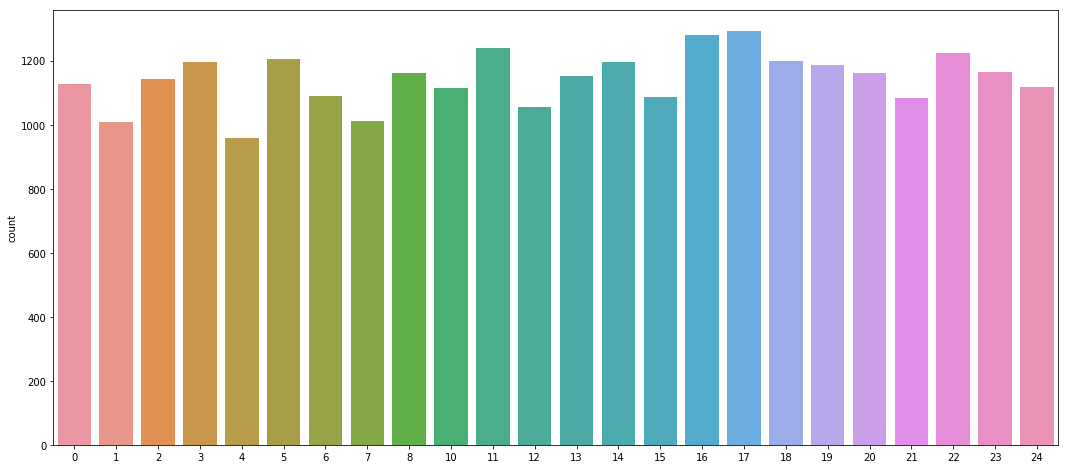

In [6]:
plt.figure(figsize = (18, 8))
sns.countplot(x = labels)

Create Dataset of Training Data

In [7]:
class AmericanSignsDataset(Dataset):
    """ASL Training Dataset"""
    
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.signs_frame = pd.read_csv(csv_file)
        self.labels_frame = self.signs_frame['label']
        self.signs_frame.drop('label', axis=1, inplace=True)
        self.transform = transform
                
    def __len__(self):
        return len(self.signs_frame)
    
    def __getitem__(self, idx):
        image = self.signs_frame.values[idx]
        image = np.array(image.reshape(28, 28))
        label = self.labels_frame.values[idx]

        if self.transform:
            image = self.transform(image)
            
        return (image, label)
        

We need to split a validation set off of the training data

In [8]:
transform = transforms.Compose([transforms.ToTensor()])
train_data = AmericanSignsDataset(csv_file='sign_mnist_train.csv', transform=transform)
lengths = [int(len(train_data)*0.8), int(len(train_data)*0.2)]
train_subset, val_subset = torch.utils.data.random_split(train_data, lengths)

In [9]:
train_subset

Each Dataset entry contains the sign and its label

(28, 28)


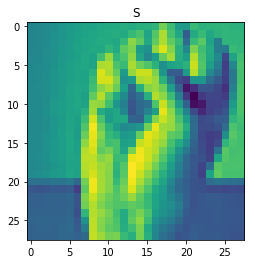

In [10]:
def imshow(img, title):
    npimg = img.numpy()
    npimg = npimg.squeeze()
    print(npimg.shape)
    plt.imshow(npimg)
    plt.title(title)
    plt.show()
imshow(train_subset[100][0], letter_dict[train_subset[100][1]])

Our DataLoader will take batches of **10** signs

tensor([14, 16, 18, 17,  8, 21, 18,  0, 18,  7])


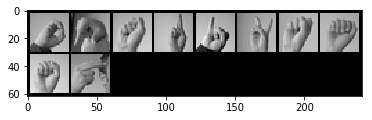

In [11]:
trainloader = DataLoader(train_subset, batch_size=10, shuffle=True, num_workers=0)
valloader = DataLoader(val_subset, batch_size=10, shuffle=True, num_workers=0)
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
show(torchvision.utils.make_grid(images))
print(labels)

Make sure our network will be run on the GPU if available

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Now we define our CNN, <br/><br/>
This model has 8 hidden layers:
- 3 Convolution layers using a 3x3 Kernel and Relu activation
- Each Conv layer is followed by a max-pooling layer
- After all Conv and Max-Pooling the results are squeezed into a 64 dense layer followed 128 size dense layer 

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 26)
        self.dropout = nn.Dropout(p=0.2)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        print(x.shape)
        # The max pool here is odd
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)
    
net = Net()
net = net.to(device)

In [36]:
net

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
  (dropout): Dropout(p=0.2)
  (softmax): LogSoftmax()
)

Using **Cross Entropy** for loss and **Stochastic Gradient Descent** with momentum<br />
Cross Entropy is a common loss used for classification problems, SGD makes the progress of gradient descent but avoid having to look at the entire dataset on each step. The momentum also helps break through any local minima that we may run into.

In [37]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

Time to train! I'm running the training data through the model for 5 epochs.

In [38]:
loss_log = []
for epoch in range(20): # loop over dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Debug
       # print(type(inputs))
       # print(labels.size())
        #print(inputs.size())
        #print(inputs.dim())
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs.float())
        
        #print(outputs.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499: # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 500))
            loss_log.append(running_loss / 500)
            running_loss = 0.0
            
print('Finished Training')

torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10

torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10

torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10

torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])
torch.Size([10, 64, 13, 13])


KeyboardInterrupt: 

Text(0, 0.5, 'loss')

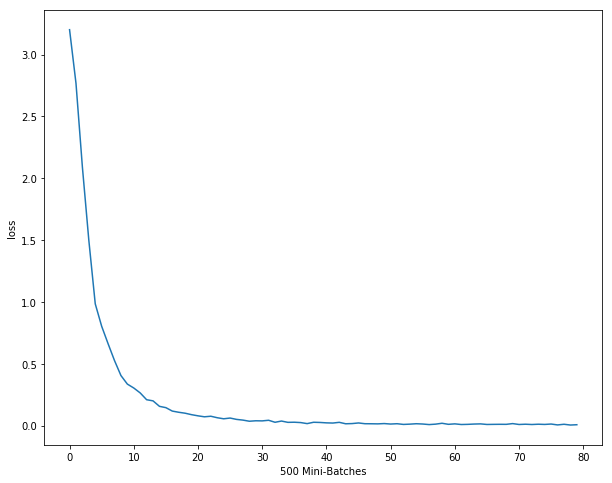

In [30]:
%matplotlib inline

plt.figure(figsize=(10,8))
plt.plot(loss_log)
plt.xlabel('500 Mini-Batches')
plt.ylabel('loss')
#plt.plot(np.ones(len(acc_log)), linestyle='dashed')

The more we train on the same data, the higher chance of **overfitting** so we must use our validation set to keep our model in check.

GroundTruth:      F     O     N     O     S     W     B     Q     Q     G


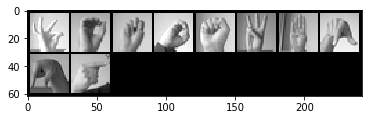

In [31]:
dataiter = iter(valloader)
images, labels = dataiter.next()

# Print images
show(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % letter_dict[labels[j].item()] for j in range(10)))

In [32]:
outputs = net(images.float().to(device))

In [33]:
_, predicted = torch.max(outputs, 1)

print('Predictied: ', ' '.join('%5s' % letter_dict[predicted[j].item()] for j in range(10)))

Predictied:      F     O     N     T     S     W     B     Q     Q     G


Results with Validation set:

In [34]:
correct = 0
total = 0
y_pred = np.array([])
y_actual = np.array([])
with torch.no_grad():
    for data in valloader:
        images, labels = data
        outputs = net(images.float().to(device))
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred = np.append(y_pred, predicted.cpu().numpy())
        y_actual = np.append(y_actual, labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        
print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct/total))

Accuracy of the network on the validation images: 99 %


**Confusion matrix** of results:

In [28]:
from sklearn.metrics import confusion_matrix
print(y_pred)
print(y_actual)
confusion_matrix(y_actual, y_pred)

[15. 18. 24. ...  7. 15. 11.]
[15. 18. 24. ...  7. 15. 11.]


array([[234,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0, 193,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0, 215,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 260,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0],
       [  0,   0,   0,   0, 205,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 227,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 238,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       235
         1.0       1.00      0.99      1.00       194
         2.0       1.00      0.99      1.00       217
         3.0       1.00      0.98      0.99       264
         4.0       1.00      1.00      1.00       205
         5.0       0.99      1.00      1.00       227
         6.0       0.98      1.00      0.99       239
         7.0       0.99      0.99      0.99       196
         8.0       1.00      1.00      1.00       208
        10.0       0.99      0.98      0.99       191
        11.0       1.00      0.99      0.99       259
        12.0       1.00      0.98      0.99       186
        13.0       1.00      1.00      1.00       228
        14.0       0.98      1.00      0.99       237
        15.0       0.99      0.99      0.99       238
        16.0       1.00      1.00      1.00       272
        17.0       0.99      0.99      0.99       267
        18.0       0.98    

The following are tunable hyperparams:
- batch size
- epochs
- learning rate
- momentum
- dropout prob

Set up confusion matrix: